<a href="https://colab.research.google.com/github/aneeshoberoi/churnhw/blob/main/Churn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as stapi
import statsmodels.regression.linear_model as sm
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.precision",2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
source='https://raw.githubusercontent.com/aneeshoberoi/churnhw/main/churn_homework%20-%20homework_orders.csv?token=AP7KM2WWRAAEJ3UOTQRIXXK7TSHIO'
raw=pd.read_csv(source, sep=",")

In [3]:
#raw=df.head(100)
#raw.set_index('order_id')

In [4]:
# assigning to working copy for indicator variables

# **Basic Statistics**

In [5]:
raw.customer.nunique()

10316

In [6]:
raw.restaurant_total.sum()

1372249.61

In [7]:
raw.order_id.nunique()

42198

In [8]:
raw.customer.isna().sum()

5

# ***Data Cleaning***

In [9]:
# assigning to working copy for indicator variables
test=raw

In [10]:
# Remove zero dollar txns
test=test[test['restaurant_total']>0]

In [11]:
# Remove rows with customer number = na
test=test.dropna(subset=['customer'])

In [12]:
test.customer.nunique()

10316

In [13]:
test.order_id.nunique()

41906

In [14]:
test.restaurant_total.sum()

1372113.6300000001

In [15]:
# Variable Conversion
test['date_purchased']=pd.to_datetime(test['date_purchased'])
test['dateonly_purchased']=test['date_purchased'].dt.date
test['houronly_purchased']=test['date_purchased'].dt.hour
test['datehour_purchased']=test['dateonly_purchased'].astype(str) + "-" + test['houronly_purchased'].astype(str)

test['restaurant_total']=test['restaurant_total'].astype(float)

In [16]:
# Removing Duplicate Txns - i.e. those made within the same hour at the same shop by a given customer. Keeping last txn only.
test=test.drop_duplicates(subset=['customer', 'shops_id', 'datehour_purchased'], keep='last')


In [17]:
test.customer.nunique()

10316

In [18]:
test.order_id.nunique()

39880

In [19]:
test.restaurant_total.sum()

1301395.08

# ***Data Prep - Indicators***

In [20]:
 #Enumerating Purchases
 test.sort_values(by=['customer','date_purchased'])

test = test.assign(order_enum=test.groupby('customer')['datehour_purchased'].cumcount()+1)
test['total_order']=test.groupby('customer')['order_id'].transform('count')
test['total_sales']=test.groupby('customer')['restaurant_total'].transform('sum')

In [21]:
test['bin_orders']=np.where(test['total_order']<7,test['order_enum'],7)

In [22]:
# Calculating Journey Data

test['time_between_purch']=test.groupby(['customer'])['date_purchased'].diff()
test['spend_growth']=test.groupby(['customer'])['restaurant_total'].diff()
test['date_last_purch']=test.groupby(['customer'])['date_purchased'].transform('max')


# Preparing Zip-Cust Level Variables




In [23]:
#Assigning raw dataset to working copy for this section
shopszip=test[['postal_code', 'shops_id','customer','total_order']].set_index('postal_code')
shopszip=shopszip.drop_duplicates(subset=['customer', 'shops_id'], keep='last')

In [24]:
# calculating shops and customers per postal code
shopszip['shops_per_zip']=shopszip.groupby('postal_code').shops_id.nunique()
shopszip['cust_per_zip']=shopszip.groupby('postal_code').customer.nunique()
shopszip['shops_per_cust_per_zip']=shopszip['shops_per_zip']/shopszip['cust_per_zip']

In [25]:
# Of customers placing orders in a given zip, what # and  % have placed more than 2 orders in total?
temp=shopszip[shopszip['total_order']>1]
shopszip['zip_cust_2_more']=temp.groupby('postal_code')['customer'].count()
shopszip['zip_pct_cust_2_more']=shopszip['zip_cust_2_more']*100/shopszip['cust_per_zip']

# ***Preparing Shop-Cust Level Variables***

In [26]:
#Total customers served by each shop

In [27]:
shopscust=shopszip.set_index('shops_id')
shopscust=shopscust.drop(columns=['shops_per_zip','cust_per_zip','zip_cust_2_more', 'zip_pct_cust_2_more','shops_per_cust_per_zip'] )

# How many customers have placed at least one order at a given shop?

shopscust['cust_per_shop']=shopscust.groupby('shops_id').customer.nunique()

In [28]:
# Of customers placing orders at a given shop, what # and % have placed > 2 total orders/
t=shopscust[shopscust['total_order']>1]
shopscust['shop_cust_2_more']=t.groupby('shops_id')['customer'].count()
shopscust['shop_pct_cust_2_more']=shopscust['shop_cust_2_more']*100/shopscust['cust_per_shop']

# ***Preparing Shop-Sales Level Variables***

In [29]:
shopsales=test[['shops_id','customer','order_id','restaurant_total']] 

In [30]:
shopsales['total_shop_sales']=shopsales.groupby('shops_id').restaurant_total.transform('sum')
shopsales['total_shop_orders']=shopsales.groupby('shops_id').order_id.transform('count')
shopsales['total_shop_cust_base']=shopsales.groupby('shops_id').customer.transform('nunique')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [31]:
shopsales=shopsales.drop_duplicates(subset=['shops_id'], keep='last').drop(columns=['customer','order_id','restaurant_total'])

In [32]:
shopsales['sales_qunitiles']=pd.qcut(shopsales['total_shop_sales'],5,labels=False)
shopsales['order_qunitiles']=pd.qcut(shopsales['total_shop_orders'].rank(method='first'),5,labels=False)

#pd.qcut(df['a'].rank(method='first'), 3, labels=False)

# ***Combining to create final analytical dataset***

In [33]:
shopscust_final=shopscust.reset_index()
shopscust_final=shopscust_final.drop_duplicates(subset=['shops_id'], keep='last').drop(columns=['customer','total_order']).set_index('shops_id')


In [34]:
shopscust_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6058 entries, 24807 to 18948
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cust_per_shop         6058 non-null   int64  
 1   shop_cust_2_more      5213 non-null   float64
 2   shop_pct_cust_2_more  5213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 189.3 KB


In [35]:
# Merging shopscust with original dataset

test2=test.merge(shopscust_final,left_on='shops_id',right_on='shops_id') 


In [36]:
# Merging shopszip with original dataset
shopszip_final=shopszip.reset_index()
shopszip_final=shopszip_final.drop_duplicates(subset=['postal_code'], keep='last').drop(columns=['customer','total_order']).set_index('shops_id')
shopszip_final.info()
#shopscustzip_final=shopscustzip.drop(columns=['customer','total_order'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3397 entries, 35952 to 18948
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   postal_code             3397 non-null   int64  
 1   shops_per_zip           3397 non-null   int64  
 2   cust_per_zip            3397 non-null   int64  
 3   shops_per_cust_per_zip  3397 non-null   float64
 4   zip_cust_2_more         3005 non-null   float64
 5   zip_pct_cust_2_more     3005 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 185.8 KB


In [37]:
shopszip_final.set_index('postal_code')
test3=test2.merge(shopszip_final,left_on='postal_code',right_on='postal_code') 

In [38]:
# Merging shopsales with original dataset
test4=test3.merge(shopsales,left_on='shops_id',right_on='shops_id')

In [39]:
## add more data operation statements here if needed

# ***Customer Level Dataset Creation***

In [40]:
test4.customer.nunique()

10316

In [41]:
# First Purchase Characteristics

fp=test4[test4['order_enum']==1]

In [42]:
fp_final=fp[['customer','date_purchased','date_last_purch','source','promo_value','shops_id','postal_code','total_order','total_sales','sales_qunitiles','order_qunitiles','zip_pct_cust_2_more','shop_pct_cust_2_more','shops_per_zip', 'shops_per_cust_per_zip']].rename(columns={'date_purchased':'fp_date','date_last_purch': 'lp_date','source':'fp_source','promo_value':'fp_promo_val','shops_id':'fp_shops_id','postal_code':'fp_postal_code','sales_quintiles':'fp_shop_sales_quintile','order_quintiles':'fp_shop_order_qunitile','zip_pct_cust_2_more':'fp_zip_cust_loyalty_score','shop_pct_cust_2_more':'fp_shop_cust_loyalty_score'})

fp_final['customer_sales_centiles']=pd.qcut(fp_final['total_sales'].rank(method='first'),100,labels=False)
fp_final['customer_order_centiles']=pd.qcut(fp_final['total_order'].rank(method='first'),100,labels=False)

In [43]:
fp_final['end_date']=test['date_purchased'].max()
fp_final['time_since_fp']=((fp_final['end_date']-fp_final['fp_date']).dt.days.astype('int16'))
fp_final['time_since_lp']=((fp_final['end_date']-fp_final['lp_date']).dt.days.astype('int16'))
fp_final['total_order_benchmark']=(fp_final['time_since_fp']*0.5/30).round(0) #6 pizza per year = 0.5 pizza per 30 days
fp_final['total_surplus_orders']=fp_final['total_order']-fp_final['total_order_benchmark']

# make customer total sales and total order centiles, total order benchmark, surplus, shops per zip H/M/L



In [44]:
#Subsequent Purchase -- Value up to 6th purchase

subs_purchase = test4[(test4['order_enum'] <7)]

In [45]:
subs_purchase_value_final=subs_purchase.pivot(index='customer',columns='order_enum', values='restaurant_total').reset_index().add_prefix('total_spend_')
subs_purchase_value_final.rename(columns={'total_spend_customer':'customer'}).fillna(0)

#subs_purchase_final.drop(columns=['order_enum'])

order_enum,customer,total_spend_1,total_spend_2,total_spend_3,total_spend_4,total_spend_5,total_spend_6
0,"1,920,771,353.00",46.42,0.00,0.00,0.00,0.00,0.00
1,"4,042,653,893.00",30.51,18.36,25.34,15.51,0.00,0.00
2,"4,555,796,885.00",29.78,0.00,0.00,0.00,0.00,0.00
3,"6,033,333,473.00",12.24,0.00,0.00,0.00,0.00,0.00
4,"6,036,185,756.00",44.75,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
10311,"51,227,013,587.00",35.70,35.79,42.25,54.54,0.00,0.00
10312,"57,523,677,443.00",12.39,22.29,23.28,20.64,0.00,0.00
10313,"120,495,000,000.00",5.82,0.00,0.00,0.00,0.00,0.00
10314,"217,278,000,000.00",16.84,0.00,0.00,0.00,0.00,0.00


In [46]:
subs_purchase_value_final['spend_growth_2']=(subs_purchase_value_final['total_spend_2']-subs_purchase_value_final['total_spend_1'])*100/subs_purchase_value_final['total_spend_1']
subs_purchase_value_final['spend_growth_3']=(subs_purchase_value_final['total_spend_3']-subs_purchase_value_final['total_spend_2'])*100/subs_purchase_value_final['total_spend_2']
subs_purchase_value_final['spend_growth_4']=(subs_purchase_value_final['total_spend_4']-subs_purchase_value_final['total_spend_3'])*100/subs_purchase_value_final['total_spend_3']
subs_purchase_value_final['spend_growth_5']=(subs_purchase_value_final['total_spend_5']-subs_purchase_value_final['total_spend_4'])*100/subs_purchase_value_final['total_spend_4']
subs_purchase_value_final['spend_growth_6']=(subs_purchase_value_final['total_spend_6']-subs_purchase_value_final['total_spend_5'])*100/subs_purchase_value_final['total_spend_5']

In [47]:
#Subsequent Purchase -- Time up to 6th purchase
subs_purchase_time_final=subs_purchase.pivot(index='customer',columns='order_enum', values='time_between_purch').reset_index().add_prefix('time_to_')

# Converting time between purchases to days
subs_purchase_time_final['time_to_2']=subs_purchase_time_final['time_to_2'].dt.days
subs_purchase_time_final['time_to_3']=subs_purchase_time_final['time_to_3'].dt.days
subs_purchase_time_final['time_to_4']=subs_purchase_time_final['time_to_4'].dt.days
subs_purchase_time_final['time_to_5']=subs_purchase_time_final['time_to_5'].dt.days
subs_purchase_time_final['time_to_6']=subs_purchase_time_final['time_to_6'].dt.days

subs_purchase_time_final.rename(columns={'time_to_customer':'customer'}).drop(columns=['time_to_1'])

order_enum,customer,time_to_2,time_to_3,time_to_4,time_to_5,time_to_6
0,"1,920,771,353.00",nan,nan,nan,nan,nan
1,"4,042,653,893.00",36.00,11.00,2.00,nan,nan
2,"4,555,796,885.00",nan,nan,nan,nan,nan
3,"6,033,333,473.00",nan,nan,nan,nan,nan
4,"6,036,185,756.00",nan,nan,nan,nan,nan
...,...,...,...,...,...,...
10311,"51,227,013,587.00",18.00,24.00,203.00,nan,nan
10312,"57,523,677,443.00",30.00,195.00,17.00,nan,nan
10313,"120,495,000,000.00",nan,nan,nan,nan,nan
10314,"217,278,000,000.00",nan,nan,nan,nan,nan


In [48]:
cust_final_dataset=fp_final.merge(subs_purchase_value_final,left_on='customer',right_on='total_spend_customer') 

In [49]:
cust_final_dataset=cust_final_dataset.merge(subs_purchase_time_final,left_on='customer',right_on='time_to_customer') 

# ***Exporting Dataset for usage in Tableau***

In [50]:
#test4.to_csv('fin_an_dataset.csv',index=False)
#cust_final_dataset.to_csv("cust_final_dataset.csv", sep="\t", index=False)
#cust_final_dataset.to_excel('cust_final_dataset.xlsx', sheet_name='raw')

In [51]:
cust_final_dataset.head()

,customer,fp_date,lp_date,fp_source,fp_promo_val,fp_shops_id,fp_postal_code,total_order,total_sales,sales_qunitiles,order_qunitiles,fp_zip_cust_loyalty_score,fp_shop_cust_loyalty_score,shops_per_zip,shops_per_cust_per_zip,customer_sales_centiles,customer_order_centiles,end_date,time_since_fp,time_since_lp,total_order_benchmark,total_surplus_orders,total_spend_customer,total_spend_1,total_spend_2,total_spend_3,total_spend_4,total_spend_5,total_spend_6,spend_growth_2,spend_growth_3,spend_growth_4,spend_growth_5,spend_growth_6,time_to_customer,time_to_1,time_to_2,time_to_3,time_to_4,time_to_5,time_to_6
0,"13,315,067,198.00",2019-03-13 08:02:07+00:00,2019-06-22 07:38:20+00:00,iosapp,0,24597,21162,2,32.21,1,2,100.00,100.00,1,0.50,21,31,2020-05-11 19:13:14+00:00,425,324,7.00,-5.00,"13,315,067,198.00",15.50,16.71,nan,nan,nan,nan,7.81,nan,nan,nan,nan,"13,315,067,198.00",NaT,100.00,nan,nan,nan,nan
1,"12,316,161,278.00",2019-08-15 08:58:47+00:00,2019-09-24 10:01:02+00:00,iosapp,4,24597,21162,2,38.20,1,2,100.00,100.00,1,0.50,27,31,2020-05-11 19:13:14+00:00,270,230,4.00,-2.00,"12,316,161,278.00",13.95,24.25,nan,nan,nan,nan,73.84,nan,nan,nan,nan,"12,316,161,278.00",NaT,40.00,nan,nan,nan,nan
2,"15,557,129,447.00",2019-03-13 08:11:38+00:00,2020-03-29 12:58:54+00:00,iosapp,0,64392,12944,5,152.83,3,4,120.00,100.00,2,0.40,78,78,2020-05-11 19:13:14+00:00,425,43,7.00,-2.00,"15,557,129,447.00",24.83,48.27,40.86,12.26,26.61,nan,94.40,-15.35,-70.00,117.05,nan,"15,557,129,447.00",NaT,48.00,182.00,141.00,10.00,nan
3,"15,557,162,096.00",2019-04-13 15:24:04+00:00,2020-05-11 15:12:51+00:00,partner_website,0,64392,12944,44,"1,316.66",3,4,120.00,100.00,2,0.40,99,99,2020-05-11 19:13:14+00:00,394,0,7.00,37.00,"15,557,162,096.00",39.67,21.91,43.98,19.78,21.00,15.53,-44.77,100.73,-55.03,6.17,-26.05,"15,557,162,096.00",NaT,40.00,12.00,35.00,6.00,5.00
4,"21,494,990,414.00",2020-03-23 16:19:50+00:00,2020-03-29 14:44:52+00:00,partner_website,0,140271,12944,2,55.88,4,4,120.00,100.00,2,0.40,41,31,2020-05-11 19:13:14+00:00,49,43,1.00,1.00,"21,494,990,414.00",26.86,29.02,nan,nan,nan,nan,8.04,nan,nan,nan,nan,"21,494,990,414.00",NaT,5.00,nan,nan,nan,nan


# ***Define Cohorts Based on First Order***

In [52]:
cust_final_dataset.fp_source.value_counts()

partner_website    5991
iosapp             2861
slicelife          1150
partner_button      148
androidapp          132
web                  31
call-center           2
google                1
Name: fp_source, dtype: int64

In [53]:
# Grouping Source of Entry
def source(df):
  if df['fp_source'] in ('iosapp', 'androidapp'):
    return 'Owned-App'
  elif df['fp_source'] in ('slicelife'):
    return 'Owned-Web'
  elif df['fp_source'] in ('partner_website','partner_button'):
    return 'Partner-Web'
  else:
    return 'Other'

In [54]:
# Grouping Use of Promo in First Purchase
def promo(df):
  if df['fp_promo_val'] > 0:
    return 'FP: Promo Used'
  else:
    return 'FP: Promo Not Used'

In [55]:
# Grouping Shops per Zip
def shops_per_zip(df):
  if df['shops_per_zip']==1:
    return "FP Zip: # Shops = 1"
  elif df['shops_per_zip'] in (2,3):
    return "FP Zip: # Shops = 2-3"
  else:
    return "FP Zip: # Shops = 4+"

In [56]:
cust_final_dataset.fp_shop_cust_loyalty_score.quantile([.05,.1,.2,.25,.5, 0.51,.66,.75,.9,1])

0.05    33.33
0.10    50.00
0.20    57.14
0.25    66.67
0.50    83.33
0.51    83.33
0.66   100.00
0.75   100.00
0.90   100.00
1.00   100.00
Name: fp_shop_cust_loyalty_score, dtype: float64

In [57]:
# Grouping Shop Cust Loyalty Score
def shop_loyalty(df):
  if df['fp_shop_cust_loyalty_score']<=50:
    return "FP Shop Loyalty: Low"
  elif df['fp_shop_cust_loyalty_score']<=80:
    return "FP Shop Loyalty: Medium"
  else:
    return "FP Shop Loyalty: High"

In [58]:
cust_final_dataset.fp_zip_cust_loyalty_score.quantile([.05,.1,.2,.25,.5,.66,.75,.9,1])

0.05    42.86
0.10    50.00
0.20    60.00
0.25    66.67
0.50    85.71
0.66   100.00
0.75   100.00
0.90   116.67
1.00   250.00
Name: fp_zip_cust_loyalty_score, dtype: float64

In [59]:
# Grouping Shop Cust Loyalty Score
def zip_loyalty(df):
  if df['fp_zip_cust_loyalty_score']<=50:
    return "FP Zip Loyalty: Low"
  elif df['fp_zip_cust_loyalty_score']<=80:
    return "FP Zip Loyalty: Medium"
  else:
    return "FP Zip Loyalty: High"

In [60]:
cust_final_dataset.head()

,customer,fp_date,lp_date,fp_source,fp_promo_val,fp_shops_id,fp_postal_code,total_order,total_sales,sales_qunitiles,order_qunitiles,fp_zip_cust_loyalty_score,fp_shop_cust_loyalty_score,shops_per_zip,shops_per_cust_per_zip,customer_sales_centiles,customer_order_centiles,end_date,time_since_fp,time_since_lp,total_order_benchmark,total_surplus_orders,total_spend_customer,total_spend_1,total_spend_2,total_spend_3,total_spend_4,total_spend_5,total_spend_6,spend_growth_2,spend_growth_3,spend_growth_4,spend_growth_5,spend_growth_6,time_to_customer,time_to_1,time_to_2,time_to_3,time_to_4,time_to_5,time_to_6
0,"13,315,067,198.00",2019-03-13 08:02:07+00:00,2019-06-22 07:38:20+00:00,iosapp,0,24597,21162,2,32.21,1,2,100.00,100.00,1,0.50,21,31,2020-05-11 19:13:14+00:00,425,324,7.00,-5.00,"13,315,067,198.00",15.50,16.71,nan,nan,nan,nan,7.81,nan,nan,nan,nan,"13,315,067,198.00",NaT,100.00,nan,nan,nan,nan
1,"12,316,161,278.00",2019-08-15 08:58:47+00:00,2019-09-24 10:01:02+00:00,iosapp,4,24597,21162,2,38.20,1,2,100.00,100.00,1,0.50,27,31,2020-05-11 19:13:14+00:00,270,230,4.00,-2.00,"12,316,161,278.00",13.95,24.25,nan,nan,nan,nan,73.84,nan,nan,nan,nan,"12,316,161,278.00",NaT,40.00,nan,nan,nan,nan
2,"15,557,129,447.00",2019-03-13 08:11:38+00:00,2020-03-29 12:58:54+00:00,iosapp,0,64392,12944,5,152.83,3,4,120.00,100.00,2,0.40,78,78,2020-05-11 19:13:14+00:00,425,43,7.00,-2.00,"15,557,129,447.00",24.83,48.27,40.86,12.26,26.61,nan,94.40,-15.35,-70.00,117.05,nan,"15,557,129,447.00",NaT,48.00,182.00,141.00,10.00,nan
3,"15,557,162,096.00",2019-04-13 15:24:04+00:00,2020-05-11 15:12:51+00:00,partner_website,0,64392,12944,44,"1,316.66",3,4,120.00,100.00,2,0.40,99,99,2020-05-11 19:13:14+00:00,394,0,7.00,37.00,"15,557,162,096.00",39.67,21.91,43.98,19.78,21.00,15.53,-44.77,100.73,-55.03,6.17,-26.05,"15,557,162,096.00",NaT,40.00,12.00,35.00,6.00,5.00
4,"21,494,990,414.00",2020-03-23 16:19:50+00:00,2020-03-29 14:44:52+00:00,partner_website,0,140271,12944,2,55.88,4,4,120.00,100.00,2,0.40,41,31,2020-05-11 19:13:14+00:00,49,43,1.00,1.00,"21,494,990,414.00",26.86,29.02,nan,nan,nan,nan,8.04,nan,nan,nan,nan,"21,494,990,414.00",NaT,5.00,nan,nan,nan,nan


In [61]:
#Applying Segments to Cust Level Dataset
cust_final_dataset['cohort_fp_source']=cust_final_dataset.apply(source,axis=1)
cust_final_dataset['cohort_fp_promo_use']=cust_final_dataset.apply(promo,axis=1)
cust_final_dataset['cohort_shops_per_zip']=cust_final_dataset.apply(shops_per_zip,axis=1)
cust_final_dataset['cohort_shop_loyalty']=cust_final_dataset.apply(shop_loyalty,axis=1)
cust_final_dataset['cohort_zip_loyalty']=cust_final_dataset.apply(zip_loyalty,axis=1)


In [62]:
# Cohort Plotting

cust_subset=cust_final_dataset[['customer','time_since_fp','time_since_lp']]
cust_subset['months_since_fp']=round((cust_subset['time_since_fp']/30),0).astype(int)
cust_subset['months_since_lp']=round((cust_subset['time_since_lp']/30),0).astype(int)
cust_subset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,customer,time_since_fp,time_since_lp,months_since_fp,months_since_lp
0,"13,315,067,198.00",425,324,14,11
1,"12,316,161,278.00",270,230,9,8
2,"15,557,129,447.00",425,43,14,1
3,"15,557,162,096.00",394,0,13,0
4,"21,494,990,414.00",49,43,2,1


In [63]:
grouping=cust_subset.groupby(['months_since_fp','months_since_lp'])
cust_cohort_data=grouping['customer'].nunique()
cust_cohort_data.reset_index()

,months_since_fp,months_since_lp,customer
0,1,0,70
1,1,1,116
2,2,0,277
3,2,1,357
4,2,2,362
5,3,0,214
6,3,1,180
7,3,2,235
8,3,3,314
9,4,0,138


In [64]:
cohort_counts=cust_cohort_data.unstack('months_since_lp')
cohort_counts2=cohort_counts.cumsum(axis=1)
cohort_counts2['total_col']=cohort_counts2.max(axis=1)
cohort_counts2.sort_values(by='months_since_fp',ascending=False)

months_since_lp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,total_col
months_since_fp,,,,,,,,,,,,,,,,
14,92.00,157.00,219.00,250.00,281.00,305.00,326.00,344.00,370.00,385.00,411.00,440.00,468.00,502.00,723.00,723.00
13,60.00,111.00,162.00,201.00,227.00,256.00,277.00,300.00,331.00,357.00,378.00,409.00,458.00,664.00,nan,664.00
12,65.00,130.00,184.00,216.00,243.00,272.00,298.00,330.00,356.00,383.00,419.00,460.00,742.00,nan,nan,742.00
11,49.00,108.00,148.00,188.00,213.00,251.00,278.00,303.00,331.00,362.00,411.00,647.00,nan,nan,nan,647.00
10,75.00,160.00,217.00,258.00,302.00,353.00,389.00,427.00,472.00,552.00,835.00,nan,nan,nan,nan,835.00
9,69.00,122.00,176.00,226.00,277.00,315.00,355.00,389.00,444.00,740.00,nan,nan,nan,nan,nan,740.00
8,57.00,131.00,194.00,244.00,296.00,336.00,386.00,441.00,666.00,nan,nan,nan,nan,nan,nan,666.00
7,61.00,130.00,196.00,251.00,295.00,348.00,416.00,664.00,nan,nan,nan,nan,nan,nan,nan,664.00
6,97.00,192.00,277.00,363.00,440.00,527.00,894.00,nan,nan,nan,nan,nan,nan,nan,nan,894.00


In [65]:
cohort_sizes = cohort_counts2.iloc[:,15]
retention = cohort_counts2.div(cohort_sizes, axis=0)
retention_round = retention.round(3) * 100
retention_final=retention_round.drop(columns=['total_col'])

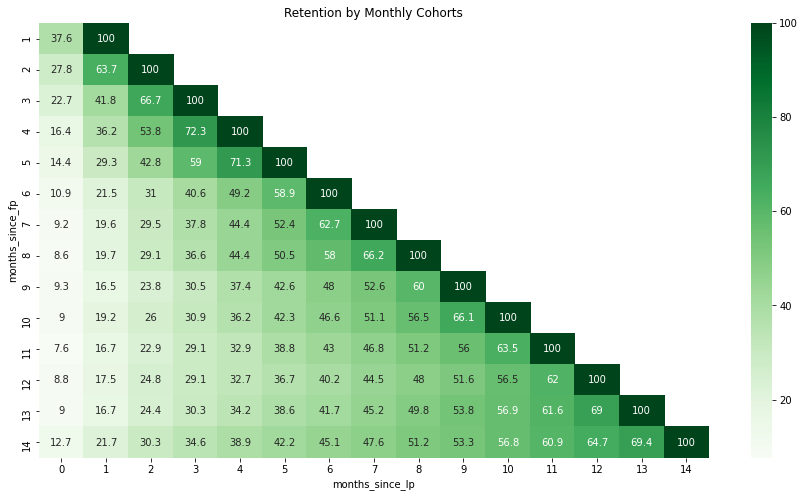

In [66]:
plt.figure(figsize=(15,8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention_final, annot=True, cmap="Greens",fmt='g')
plt.show()

In [67]:
cohort_counts=cust_cohort_data.unstack('months_since_lp')
#cohort_counts3=cohort_counts.cumsum(axis=0)
cohort_counts['total_col']=cohort_counts.sum(axis=1)
cohort_counts.sort_values(by='months_since_fp',ascending=False).reset_index()
cohort_counts

months_since_lp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,total_col
months_since_fp,,,,,,,,,,,,,,,,
1,70.00,116.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,186.00
2,277.00,357.00,362.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,996.00
3,214.00,180.00,235.00,314.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,943.00
4,138.00,166.00,148.00,155.00,233.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,840.00
5,112.00,115.00,105.00,126.00,95.00,223.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,776.00
6,97.00,95.00,85.00,86.00,77.00,87.00,367.00,nan,nan,nan,nan,nan,nan,nan,nan,894.00
7,61.00,69.00,66.00,55.00,44.00,53.00,68.00,248.00,nan,nan,nan,nan,nan,nan,nan,664.00
8,57.00,74.00,63.00,50.00,52.00,40.00,50.00,55.00,225.00,nan,nan,nan,nan,nan,nan,666.00
9,69.00,53.00,54.00,50.00,51.00,38.00,40.00,34.00,55.00,296.00,nan,nan,nan,nan,nan,740.00


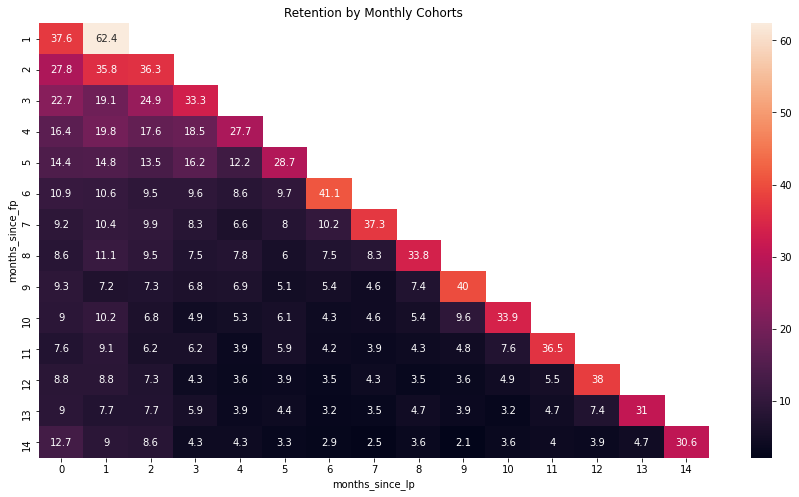

In [68]:
cohort_sizes = cohort_counts.iloc[:,15]
retention = cohort_counts.div(cohort_sizes, axis=0)
retention_round = retention.round(3) * 100
retention_final=retention_round.drop(columns=['total_col'])

plt.figure(figsize=(15,8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention_final, annot=True,fmt='g')
plt.show()

# ***Hypothesis Testing***

In [69]:
# Defining Function to test continuous variable hypotheses
def simple_regression_summary(yvar):
  
  list_of_cohort_factors=[
                          "total_order",'total_sales','time_to_2','time_since_lp','total_surplus_orders']

  output=[]
  i=0

  for cohort_factor in list_of_cohort_factors:
      formula = cohort_factor + '~' + yvar
      results=sm.OLS.from_formula(formula, data = cust_final_dataset).fit()
    #output.append(results_summary_to_dataframe(results,list_of_cohort_factors[i]))

    #take the result of an statsmodel results table and transforms it into a dataframe
    
      cvar=list_of_cohort_factors[i]
      pvals = results.pvalues
      coeff = results.params
      conf_lower = results.conf_int()[0]
      conf_higher = results.conf_int()[1]

      results_df = pd.DataFrame({"independent":cvar,
                               "pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
      results_df = results_df[['independent',"coeff","pvals","conf_lower","conf_higher"]]
      print(results_df)
      i=i+1

  return


In [70]:
# Defining Function to test categorical variable hypotheses
def anova_results_summary(yvar):
  
  list_of_cohort_factors=["total_order",'total_sales','time_to_2','time_since_lp','total_surplus_orders']

  output=[]
  i=0

  for cohort_factor in list_of_cohort_factors:
      formula = cohort_factor + '~' + yvar
      results=sm.OLS.from_formula(formula, data = cust_final_dataset).fit()
      table=stapi.stats.anova_lm(results)
      print(cohort_factor, table.iloc[0:1], "\n")
      
      i=i+1

  return 

# 1. Entry Source

In [71]:
# Categorical
(anova_results_summary('cohort_fp_source'))


total_order                    df   sum_sq  mean_sq     F  PR(>F)
cohort_fp_source 3.00 9,322.55 3,107.52 90.60    0.00 

total_sales                    df       sum_sq      mean_sq     F  PR(>F)
cohort_fp_source 3.00 7,302,655.95 2,434,218.65 61.75    0.00 

time_to_2                    df    sum_sq   mean_sq    F  PR(>F)
cohort_fp_source 3.00 55,424.82 18,474.94 4.16    0.01 

time_since_lp                    df     sum_sq    mean_sq     F  PR(>F)
cohort_fp_source 3.00 595,903.62 198,634.54 14.20    0.00 

total_surplus_orders                    df   sum_sq  mean_sq     F  PR(>F)
cohort_fp_source 3.00 4,672.30 1,557.43 45.61    0.00 



# 2. Promo Value

In [72]:
# Categorical
anova_results_summary('cohort_fp_promo_use')

total_order                       df  sum_sq  mean_sq    F  PR(>F)
cohort_fp_promo_use 1.00  208.41   208.41 5.92    0.01 

total_sales                       df  sum_sq  mean_sq    F  PR(>F)
cohort_fp_promo_use 1.00   58.25    58.25 0.00    0.97 

time_to_2                       df  sum_sq  mean_sq    F  PR(>F)
cohort_fp_promo_use 1.00    4.22     4.22 0.00    0.98 

time_since_lp                       df    sum_sq   mean_sq    F  PR(>F)
cohort_fp_promo_use 1.00 42,507.06 42,507.06 3.03    0.08 

total_surplus_orders                       df  sum_sq  mean_sq    F  PR(>F)
cohort_fp_promo_use 1.00    1.76     1.76 0.05    0.82 



In [73]:
# Continuous
simple_regression_summary('fp_promo_val')

              independent  coeff  pvals  conf_lower  conf_higher
Intercept     total_order   3.83   0.00        3.71         3.95
fp_promo_val  total_order   0.12   0.06       -0.01         0.24
              independent  coeff  pvals  conf_lower  conf_higher
Intercept     total_sales 126.06   0.00      122.03       130.09
fp_promo_val  total_sales   0.33   0.88       -3.88         4.55
             independent  coeff  pvals  conf_lower  conf_higher
Intercept      time_to_2  56.21   0.00       54.58        57.84
fp_promo_val   time_to_2   0.64   0.44       -0.98         2.26
                independent  coeff  pvals  conf_lower  conf_higher
Intercept     time_since_lp 135.84   0.00      133.45       138.22
fp_promo_val  time_since_lp   1.46   0.25       -1.04         3.95
                       independent  coeff  pvals  conf_lower  conf_higher
Intercept     total_surplus_orders   0.11   0.06       -0.01         0.23
fp_promo_val  total_surplus_orders  -0.01   0.88       -0.13         

# 3. Shops Per Zip

In [74]:
anova_results_summary('cohort_shops_per_zip')

total_order                        df   sum_sq  mean_sq     F  PR(>F)
cohort_shops_per_zip 2.00 2,892.54 1,446.27 41.42    0.00 

total_sales                        df       sum_sq      mean_sq     F  PR(>F)
cohort_shops_per_zip 2.00 2,239,908.94 1,119,954.47 28.06    0.00 

time_to_2                        df    sum_sq  mean_sq    F  PR(>F)
cohort_shops_per_zip 2.00 14,539.73 7,269.87 1.64    0.19 

time_since_lp                        df    sum_sq   mean_sq    F  PR(>F)
cohort_shops_per_zip 2.00 21,901.32 10,950.66 0.78    0.46 

total_surplus_orders                        df   sum_sq  mean_sq     F  PR(>F)
cohort_shops_per_zip 2.00 1,742.37   871.19 25.31    0.00 



In [75]:
simple_regression_summary('shops_per_zip')

               independent  coeff  pvals  conf_lower  conf_higher
Intercept      total_order   3.25   0.00        3.07         3.42
shops_per_zip  total_order   0.23   0.00        0.18         0.28
               independent  coeff  pvals  conf_lower  conf_higher
Intercept      total_sales 109.16   0.00      103.20       115.12
shops_per_zip  total_sales   6.22   0.00        4.56         7.89
              independent  coeff  pvals  conf_lower  conf_higher
Intercept       time_to_2  56.49   0.00       54.08        58.90
shops_per_zip   time_to_2  -0.03   0.93       -0.69         0.62
                 independent  coeff  pvals  conf_lower  conf_higher
Intercept      time_since_lp 138.71   0.00      135.17       142.24
shops_per_zip  time_since_lp  -0.91   0.07       -1.89         0.08
                        independent  coeff  pvals  conf_lower  conf_higher
Intercept      total_surplus_orders  -0.40   0.00       -0.57        -0.22
shops_per_zip  total_surplus_orders   0.19   0.00      

# 4. Shop Loyalty

In [76]:
anova_results_summary('cohort_shop_loyalty')

total_order                       df   sum_sq  mean_sq     F  PR(>F)
cohort_shop_loyalty 2.00 6,783.31 3,391.66 98.19    0.00 

total_sales                       df       sum_sq      mean_sq     F  PR(>F)
cohort_shop_loyalty 2.00 6,675,587.97 3,337,793.99 84.55    0.00 

time_to_2                       df    sum_sq   mean_sq    F  PR(>F)
cohort_shop_loyalty 2.00 23,118.64 11,559.32 2.60    0.07 

time_since_lp                       df       sum_sq      mean_sq      F  PR(>F)
cohort_shop_loyalty 2.00 5,764,467.98 2,882,233.99 213.68    0.00 

total_surplus_orders                       df   sum_sq  mean_sq      F  PR(>F)
cohort_shop_loyalty 2.00 7,513.85 3,756.93 110.94    0.00 



In [77]:
simple_regression_summary('fp_shop_cust_loyalty_score')

                            independent  coeff  pvals  conf_lower  conf_higher
Intercept                   total_order  -0.19   0.41       -0.66         0.27
fp_shop_cust_loyalty_score  total_order   0.06   0.00        0.05         0.06
                            independent  coeff  pvals  conf_lower  conf_higher
Intercept                   total_sales  -1.56   0.85      -17.21        14.10
fp_shop_cust_loyalty_score  total_sales   1.74   0.00        1.55         1.93
                           independent  coeff  pvals  conf_lower  conf_higher
Intercept                    time_to_2  64.25   0.00       56.72        71.77
fp_shop_cust_loyalty_score   time_to_2  -0.09   0.04       -0.18        -0.01
                              independent  coeff  pvals  conf_lower  conf_higher
Intercept                   time_since_lp 256.54   0.00      248.23       264.86
fp_shop_cust_loyalty_score  time_since_lp  -1.65   0.00       -1.76        -1.55
                                     independent 

# 5. Zip Loyalty

In [78]:
anova_results_summary('fp_zip_cust_loyalty_score')

total_order                             df    sum_sq   mean_sq      F  PR(>F)
fp_zip_cust_loyalty_score 1.00 15,161.50 15,161.50 432.99    0.00 

total_sales                             df        sum_sq       mean_sq      F  PR(>F)
fp_zip_cust_loyalty_score 1.00 15,409,544.81 15,409,544.81 384.06    0.00 

time_to_2                             df    sum_sq   mean_sq    F  PR(>F)
fp_zip_cust_loyalty_score 1.00 41,427.10 41,427.10 9.33    0.00 

time_since_lp                             df       sum_sq      mean_sq      F  PR(>F)
fp_zip_cust_loyalty_score 1.00 7,361,751.49 7,361,751.49 569.20    0.00 

total_surplus_orders                             df    sum_sq   mean_sq      F  PR(>F)
fp_zip_cust_loyalty_score 1.00 14,983.88 14,983.88 438.13    0.00 



In [79]:
  simple_regression_summary('fp_zip_cust_loyalty_score')

                           independent  coeff  pvals  conf_lower  conf_higher
Intercept                  total_order   0.18   0.34       -0.20         0.56
fp_zip_cust_loyalty_score  total_order   0.04   0.00        0.04         0.05
                           independent  coeff  pvals  conf_lower  conf_higher
Intercept                  total_sales   8.85   0.18       -3.99        21.69
fp_zip_cust_loyalty_score  total_sales   1.43   0.00        1.29         1.57
                          independent  coeff  pvals  conf_lower  conf_higher
Intercept                   time_to_2  65.08   0.00       59.30        70.86
fp_zip_cust_loyalty_score   time_to_2  -0.09   0.00       -0.15        -0.03
                             independent  coeff  pvals  conf_lower  conf_higher
Intercept                  time_since_lp 215.84   0.00      208.55       223.13
fp_zip_cust_loyalty_score  time_since_lp  -0.99   0.00       -1.07        -0.91
                                    independent  coeff  pvals